# Deep learning model comparison
This notebook contains the implementation and evaluation of various neural network models with differing paremeters.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from manual_review_classifier.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa

sns.set_style("white")
sns.set_context('talk')

Using TensorFlow backend.
/Users/ebarnell/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('H_KA-452198')]
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [6]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [7]:
# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [8]:
# Set parameters for cross-validation fold splits
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [9]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [10]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [11]:
# Get labels for training data
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [12]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [13]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [14]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470, 3)

In [15]:
# Define baseline model
def three_class_model():
    # create model
    model = Sequential()
    model.add(Dense(71, input_dim=71, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# Set deep learning model parameters
estimator = KerasClassifier(build_fn=three_class_model, epochs=700, batch_size=2000, verbose=0)

In [18]:
# Develop cross validation predictions
if not os.path.exists('../data/deep_learning/threeclass_regularization.npy'):
    probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_regularization.npy')

In [19]:
# Pull maximum probability to determine call
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [20]:
# Analyze predicted labels
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [21]:
# Print accuracy report
print_accuracy_and_classification_report(Y_train, predicted_transformed)

Cross validation accuracy:
	 0.866618128868

Cross validation classification report

             precision    recall  f1-score   support

          0       0.81      0.73      0.77      7189
          1       0.90      0.91      0.91      8015
          2       0.87      0.92      0.90     12266

avg / total       0.86      0.87      0.86     27470



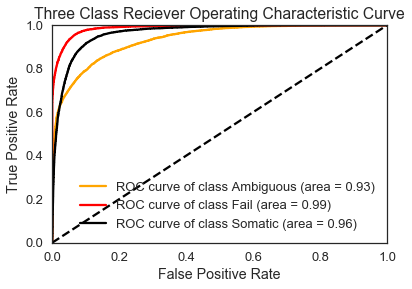

In [22]:
# Create ROC curves parsed by class
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_train, probabilities, class_lookup, 'Three Class Reciever '
                'Operating Characteristic Curve',ax)

confidence intervals +-:  [ 0.00062248  0.00456623  0.0074501   0.009447    0.01037292  0.01143201
  0.01109529  0.00861871  0.00542386  0.00122206]


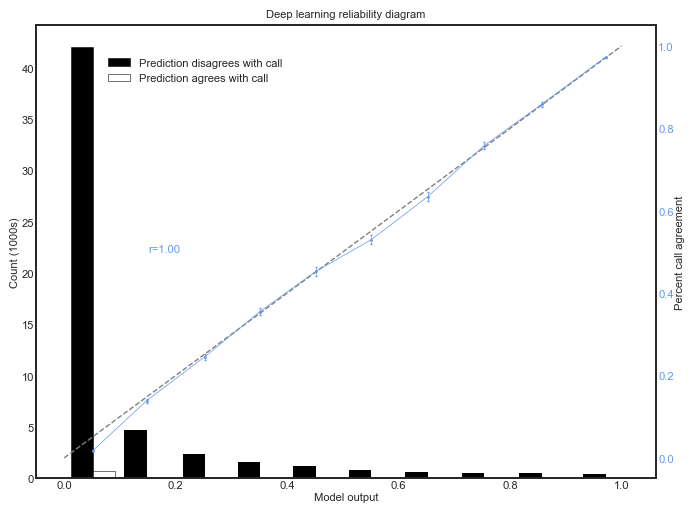

In [23]:
# Plot Reliability Diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_train,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

### Examine reliability per class call

confidence intervals +-:  [ 0.00135697  0.00597271  0.00959394  0.01293291  0.01499473  0.01900697
  0.01987522  0.01710728  0.01035055  0.00301243]


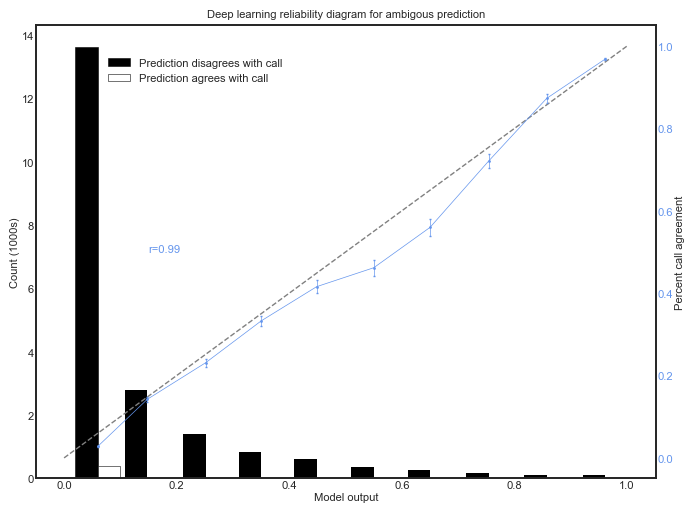

In [24]:
# Plot reliability diagram for ambiguous calls
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities[:,:1], Y_train[:,:1],['Ambiguous'], 'cornflowerblue', 'Deep learning reliability diagram for ambigous prediction',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))


confidence intervals +-:  [ 0.00068762  0.01350633  0.0196033   0.02160038  0.02095894  0.0217227
  0.02218137  0.01941442  0.01545383  0.00128575]


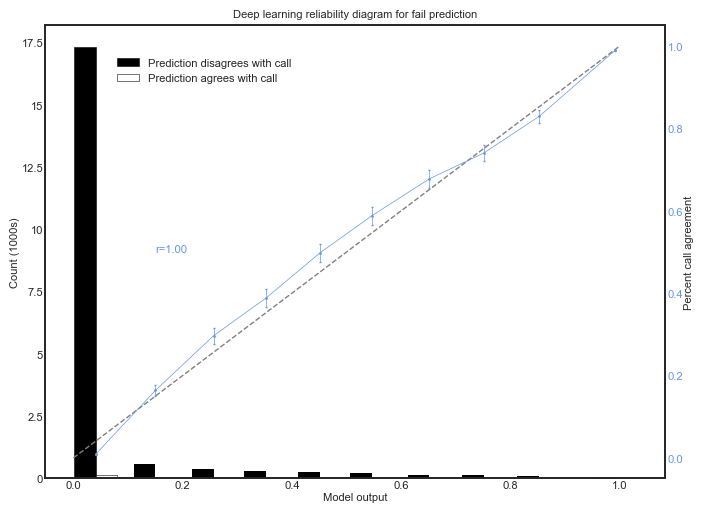

In [25]:
# Plot reliability diagram for failed calls
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities[:,1:2], Y_train[:,1:2],['Fail'], 'cornflowerblue', 'Deep learning reliability diagram for fail prediction',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))


confidence intervals +-:  [ 0.0012534   0.00820249  0.01464484  0.01790028  0.01953831  0.0187247
  0.01648875  0.01151324  0.00694974  0.00213015]


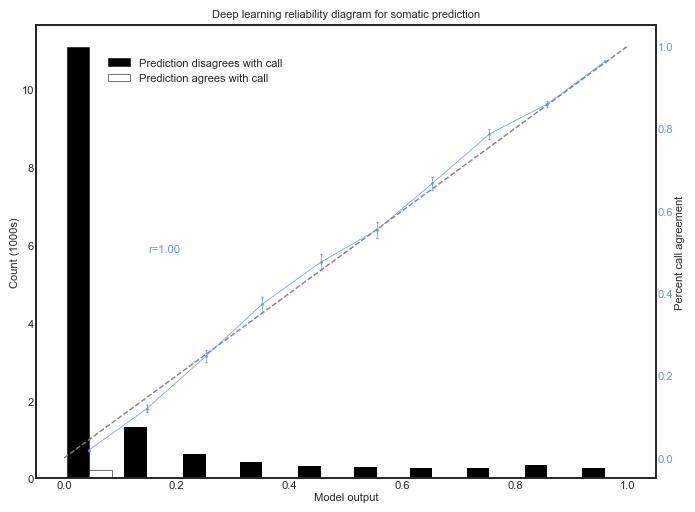

In [26]:
# Plot reliability diagram for somatic calls
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities[:,2:3], Y_train[:,2:3],['Somatic'], 'cornflowerblue', 'Deep learning reliability diagram for somatic prediction',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))


## Feature importance analysis for three class classifier

In [27]:
# Create feature importance dataframe
feature_importances = pd.DataFrame()
# Iterate through the features and estimate the AUC without; Determine most influential in building the model
for i in range(15):
    estimator.fit(X_train, Y_train)
    feat_import = determine_feature_importance(estimator, X_train, Y_train, False)
    feat_import.set_index('feature', inplace=True)
    feature_importances = pd.concat((feature_importances, feat_import))
feature_importances = feature_importances.groupby(feature_importances.index).mean()
feature_importances.reset_index(level=0, inplace=True)
feature_importances.sort_values('delta_auc', inplace=True, ascending=False)
feature_importances.to_pickle('../data/deep_learning/feature_import.pkl')

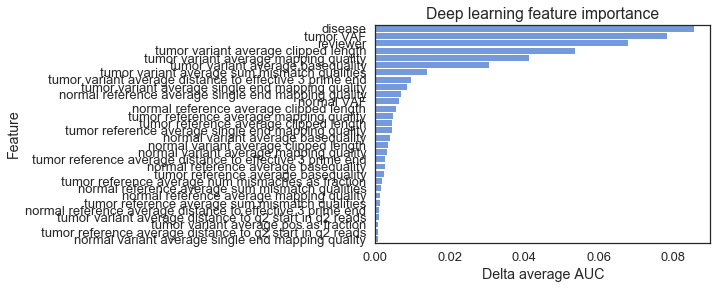

In [28]:
# Plot feature importance
create_feature_importance_plot(feature_importances, 'Deep learning feature importance')

### 1/3 Hold out set analysis

In [29]:
test_probs = estimator.predict_proba(X_test)

In [30]:
np.save('../data/deep_learning/hold_out_test_probs.npy', test_probs)
np.save('../data/deep_learning/hold_out_test_y.npy', Y_test)

In [31]:
X_test.shape

(13530, 71)

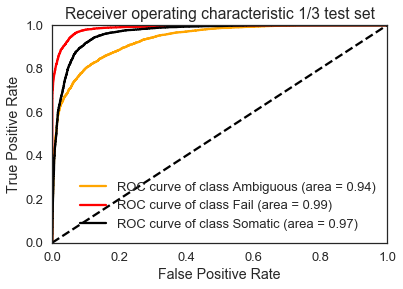

In [32]:
fig, ax = plt.subplots()
create_roc_curve(Y_test, test_probs, class_lookup, 'Receiver operating'
                 ' characteristic 1/3 test set', ax)

confidence intervals +-:  [ 0.00083314  0.00650994  0.01002082  0.0137528   0.01482996  0.01611024
  0.01564416  0.01177837  0.00760273  0.00171761]


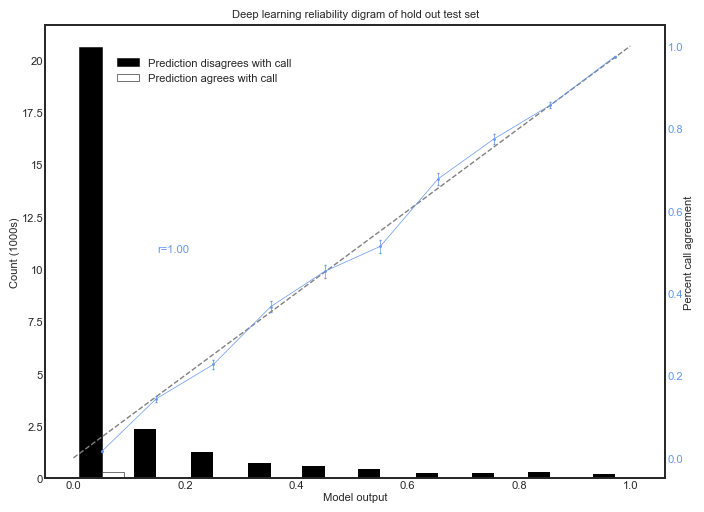

In [33]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_probs, Y_test,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability digram of hold out test set',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

# Solid vs blood tumor
Is the importance of the disease feature in the above results correspond to the known tendency for blood cancers to contain tumor cell contamination of the normal sample?

To test this question, all disease columns were recoded into a single binary variable 'solid_tumor', where False is a blood cancer (liquid tumor) and True is a solid tumor. If performance is approximately the same as earlier results, it is likely that the disease feature is based on the difference between solid and liquid tumors. Simplifying this variable would allow the model to be run on a variety of diseases.

In [34]:
three_class = training_data.replace('g','f')

In [35]:
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [36]:
s_v_b.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [37]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [38]:
X.shape

(41000, 63)

In [39]:
Y.shape

(41000, 3)

In [40]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [41]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(63, input_dim=63, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [43]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [44]:
if not os.path.exists('../data/deep_learning/solid_v_blood_regularization.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/solid_v_blood_regularization.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/solid_v_blood_regularization.npy')

In [45]:
np.save('../data/deep_learning/solid_v_blood_y.npy', Y)

In [46]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [47]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [48]:
print_accuracy_and_classification_report(Y, predicted_transformed)

Cross validation accuracy:
	 0.860780487805

Cross validation classification report

             precision    recall  f1-score   support

          0       0.79      0.72      0.76     10643
          1       0.90      0.91      0.90     11976
          2       0.87      0.91      0.89     18381

avg / total       0.86      0.86      0.86     41000



### The simplified 'solid tumor' variable maintains performance seen in earlier models
The 'solid tumor' variable adequately replaces listing individual diseases. Using this variable going forward will allow for more types of tumors to be called by this model

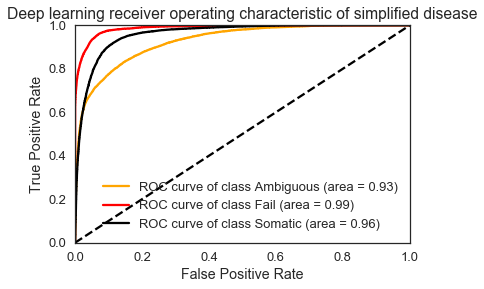

In [49]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y, probabilities, class_lookup, 'Deep learning receiver '
                 'operating characteristic of simplified disease', ax)

confidence intervals +-:  [ 0.00052688  0.00341899  0.00591293  0.00770894  0.00877777  0.00920436
  0.00858335  0.00659297  0.00397114  0.00108234]


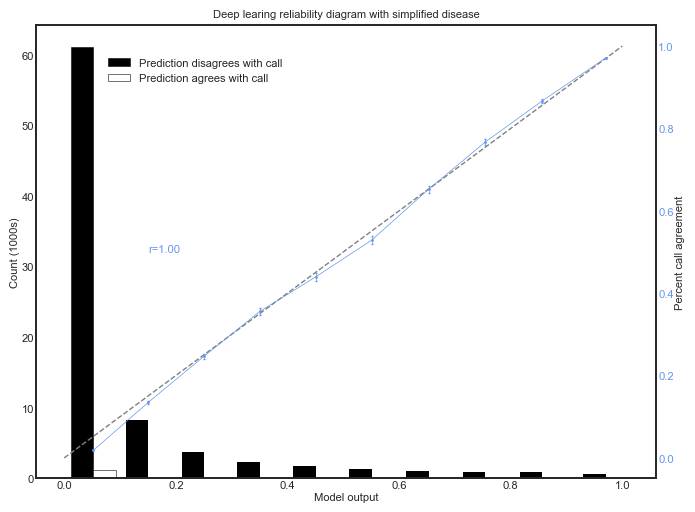

In [50]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learing reliability diagram with simplified disease',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

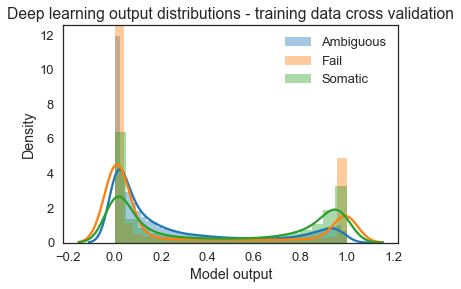

In [51]:
make_model_output_plot(probabilities, 'Deep learning output distributions -'
                       ' training data cross validation')

### Calculate kappa of model cross validation predictions

In [52]:
kappa_table = Y + predicted_transformed

In [53]:
calculate_kappa(kappa_table)

0.78329287187711594

## Remove reviewer to simulate performance on de novo datasets

In [54]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2',
                'reviewer_3', 'reviewer_4'] , axis=1).astype(float).values

In [55]:
X.shape

(41000, 59)

In [56]:
Y.shape

(41000, 3)

In [57]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [58]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [59]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [60]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [61]:
if not os.path.exists('../data/deep_learning/noreviewer_probs_regularization.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/noreviewer_probs_regularization.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/noreviewer_probs_regularization.npy')

In [62]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [63]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [64]:
print_accuracy_and_classification_report(Y, predicted_transformed)

Cross validation accuracy:
	 0.849731707317

Cross validation classification report

             precision    recall  f1-score   support

          0       0.77      0.69      0.73     10643
          1       0.89      0.90      0.90     11976
          2       0.86      0.91      0.88     18381

avg / total       0.85      0.85      0.85     41000



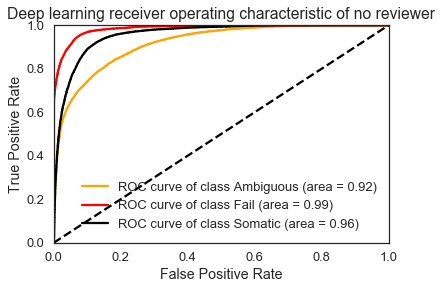

In [65]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y, probabilities, class_lookup, 'Deep learning receiver '
                 'operating characteristic of no reviewer', ax=ax)

confidence intervals +-:  [ 0.00054063  0.00342791  0.00562326  0.00748434  0.00815918  0.00873999
  0.00808578  0.00647762  0.00413643  0.0011306 ]


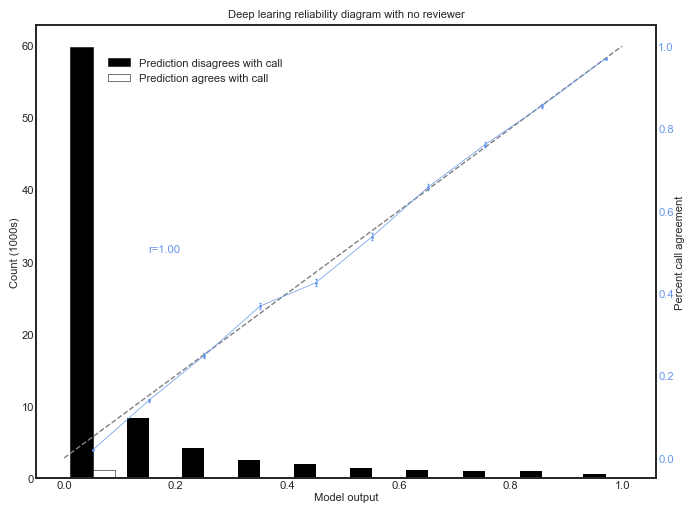

In [66]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learing reliability diagram with no reviewer',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

In [67]:
cv_somatic_error = get_somatic_error_type(Y, predicted)

In [68]:
cv_somatic_error.index = training_data.index

In [69]:
probs_df = pd.DataFrame(probabilities, columns=['Ambiguous', 'Fail', 'Somatic'], index=training_data.index)

In [70]:
cv_somatic_error = pd.concat([cv_somatic_error, probs_df], axis=1)

In [71]:
cv_somatic_error.to_pickle('../data/deep_learning/xval_model_results.pkl')

# Independent test set analysis

In [72]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array, remove reviews because of non overlap
X = s_v_b.sort_index(axis=1).drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [73]:
X.shape

(41000, 59)

In [74]:
# define baseline model
def model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [75]:
estimator = KerasClassifier(build_fn=model, epochs=1000, batch_size=2000, verbose=0)

In [76]:
estimator.fit(X, Y)

## SCLC

In [77]:
sclc_data = pd.read_pickle('../data/independent_test/sclc_train.pkl')
sclc_data['solid_tumor'] = 1

In [78]:
sclc_call = pd.read_pickle('../data/independent_test/sclc_call.pkl')
sclc_call=sclc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
sclc_call.value_counts()

s    2526
f     145
a      15
Name: call, dtype: int64

In [79]:
# Get Labels
sclc_Y = pd.get_dummies(sclc_call).astype(float).values
# Get training data as numpy array
sclc_X = sclc_data.sort_index(axis=1).drop(['disease_SCLC', 'reviewer_Erica', 'reviewer_Lee'], axis=1).astype(float).values

In [80]:
sclc_probs = estimator.predict_proba(sclc_X)

In [81]:
np.save('../data/deep_learning/sclc_y.npy', sclc_Y)
np.save('../data/deep_learning/sclc_probs.npy', sclc_probs)

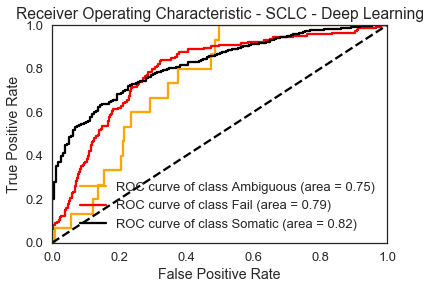

In [82]:
fig, ax = plt.subplots()
create_roc_curve(sclc_Y, sclc_probs, class_lookup, 
                 'Receiver Operating Characteristic - SCLC - Deep Learning', ax)

confidence intervals +-:  [ 0.00268968  0.02591006  0.03900446  0.04127372  0.04909887  0.05482651
  0.05449094  0.05325578  0.03360496  0.00409837]


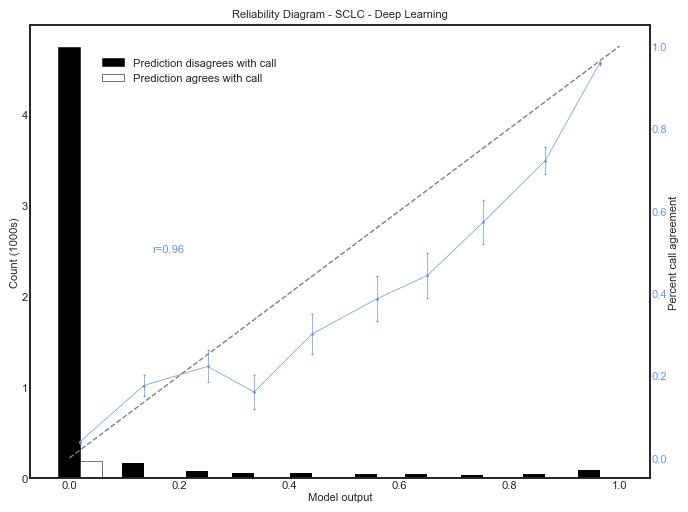

In [83]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(sclc_probs, sclc_Y,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'cornflowerblue', 
                                 'Reliability Diagram - SCLC - Deep Learning',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

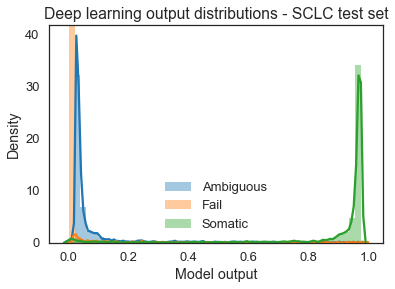

In [84]:
make_model_output_plot(sclc_probs, 'Deep learning output distributions -'
                       ' SCLC test set')

In [85]:
label_binarizer.fit(range(max(estimator.predict(sclc_X))+1))
sclc_predicted_transformed = label_binarizer.transform(estimator.predict(sclc_X))

calculate_kappa(sclc_predicted_transformed+sclc_Y)

0.14648244572970509

In [86]:
metrics.cohen_kappa_score(np.argmax(sclc_Y, axis=1), estimator.predict(sclc_X))

0.15273465300743361

In [87]:
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        sclc_X_test = sclc_X
        sclc_Y_test = sclc_Y
        X_train = X
        Y_train = Y
    else:
        (sclc_X_train, sclc_X_test, 
         sclc_Y_train, sclc_Y_test) = train_test_split(sclc_X, sclc_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=sclc_Y) 
        X_train = np.concatenate((X, sclc_X_train))
        Y_train = np.concatenate((Y, sclc_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', sclc_X_test.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_test_probs = estimator.predict_proba(sclc_X_test)
    print_accuracy_and_classification_report(sclc_Y_test, predict_classes(X_test_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    for j in range(Y.shape[1]):
        temp_auc.append(metrics.roc_auc_score(sclc_Y_test[:, j], X_test_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41000, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.940059568131

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.49      0.14      0.22       145
          2       0.95      0.99      0.97      2526

avg / total       0.92      0.94      0.93      2686

Test AUC:  [0, 0.85413702733058783, 0.90333428327158727, 0.88774247822644492]
---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Percentage of test data included in training:  5.0
Training data shape:  (41134, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134
Cross validation accuracy:
	 0.939263322884

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        14
          1       0.51      0.24      0.33       138
          2       0.96      0.98      0.97      2400

avg / total       0.93      0.94      0.93      2552

Test AUC:  [134, 0.74372396712822242, 0.9043892511076691, 0.88798930921052621]
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (41268, 59)
Test data shape:  (2418, 59)
Number of test samples included in training:  268
Cross validation accuracy:
	 0.939619520265

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00

---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (42880, 59)
Test data shape:  (806, 59)
Number of test samples included in training:  1880
Cross validation accuracy:
	 0.950372208437

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.69      0.50      0.58        44
          2       0.97      0.98      0.98       758

avg / total       0.95      0.95      0.95       806

Test AUC:  [1880, 0.73940149625935159, 0.92853734192316884, 0.93189313984168876]
---------------------------------------------------------
Percentage of test data included in training:  75.0
Training data shape:  (43014, 59)
Test data shape:  (672, 59)
Number of test samples included in training:  2014
Cross validation accuracy:
	 0.956845238095

Cross validation classification report

             precision    recall  f

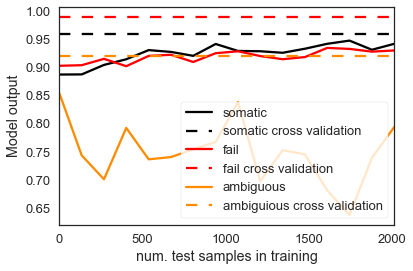

In [88]:
try:
    sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
    sclc_auc.to_pickle('../data/deep_learning/sclc_batch_effect_correction_dropout.pkl')
except NameError:
    sclc_auc = pd.read_pickle('../data/deep_learning/sclc_batch_effect_correction_dropout.pkl')
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend(loc=4,frameon=True)

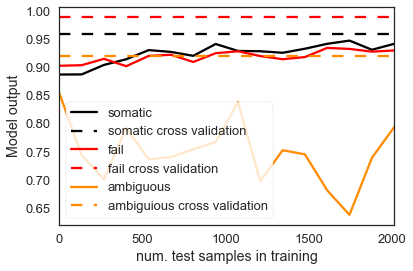

In [89]:
try:
    sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
    sclc_auc.to_pickle('../data/deep_learning/sclc_batch_effect_correction.pkl')
except NameError:
    sclc_auc = pd.read_pickle('../data/deep_learning/sclc_batch_effect_correction.pkl')
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend(frameon=True)